In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import seaborn as sns

In [86]:

model_predictions = np.load("results/pred_20251124_220247_second_best_val.npy")
ground_truths = np.load("results/ground_truths.npy")
model_samples = np.load("results/samples_20251124_220247_second_best_val.npy")
baseline_predictions = np.load("urbanev/TimeXer_predictions.npy")
baseline_predictions = np.concatenate([baseline_predictions[:, :, -1:], baseline_predictions], axis=-1)[:, :, :-1]
baseline_predictions = baseline_predictions[:model_predictions.shape[0]]
model_predictions = model_predictions[:baseline_predictions.shape[0]]
model_samples = model_samples[:baseline_predictions.shape[0]]


In [55]:
print(f"model_predictions shape:{model_predictions.shape},\n model_samples shape:{model_samples.shape},\n ground_truths shape:{ground_truths.shape}") 

model_predictions shape:(412, 12, 275),
 model_samples shape:(412, 20, 12, 275),
 ground_truths shape:(412, 12, 275)


--- 概率预测评估脚本 ---

--- 正在计算 PIT 直方图 ---
PIT 直方图已保存到: pit_histogram.png

--- 正在计算可靠性图 ---
可靠性图已保存到: reliability_diagram.png


c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.

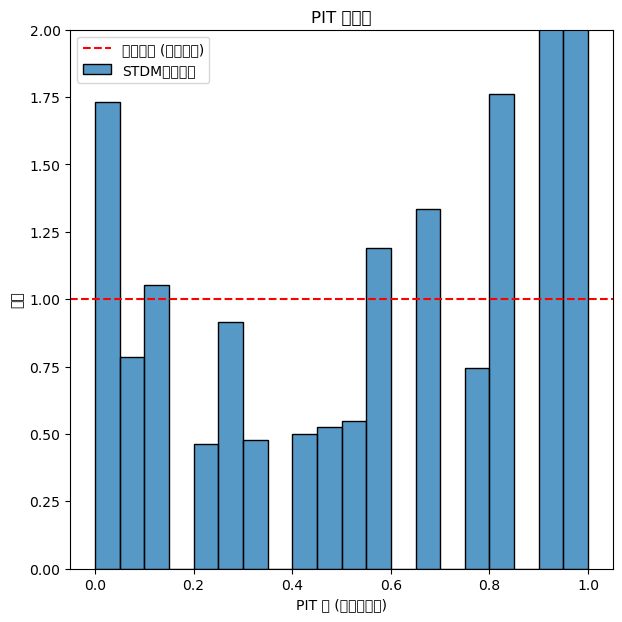

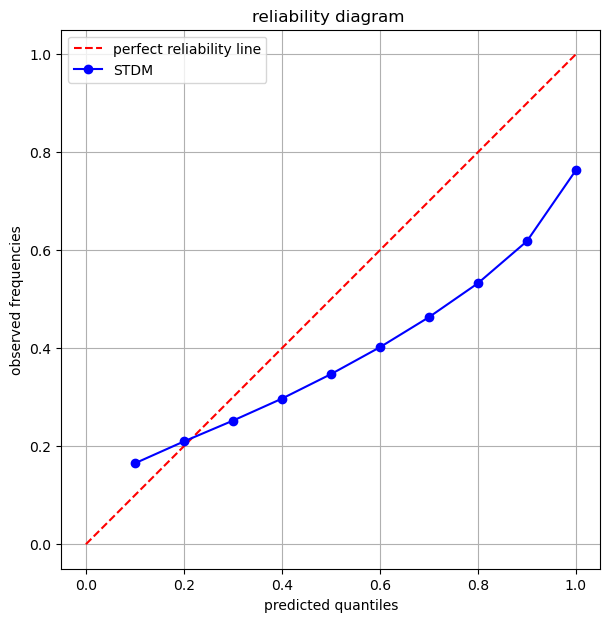

In [87]:
def calculate_pit(y_true, y_pred_samples):
    """
    计算概率积分变换 (PIT) 值。
    
    这是评估概率预测校准度的核心工具。
    它计算的是真实值 (y_true) 相对于预测样本 (y_pred_samples) 的经验分位数。
    
    参数:
    y_true (np.ndarray): 真实值数组。
                          形状: (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。
                                  形状: (B, S, L, N) 或 (num_datapoints, S)
                                  其中 S 是样本数量。

    返回:
    np.ndarray: 一维数组，包含所有数据点的 PIT 值 (范围在 0 到 1 之间)。
                如果预测完美校准，此数组应服从均匀分布。
    """
    
    # 为了进行广播比较，我们需要将 y_true 的形状扩展为 (B, 1, L, N)
    # 以便它能和 (B, S, L, N) 的 y_pred_samples 进行比较。
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        # 假设 y_true: (B, L, N), y_pred_samples: (B, S, L, N)
        # B = 批量大小, L = 预测长度, N = 节点数, S = 样本数
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (B, 1, L, N)
        sample_axis = 1 # 样本在 S 维度上
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        # 假设 y_true: (N,), y_pred_samples: (N, S)
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (N, 1)
        sample_axis = 1 # 样本在 S 维度上
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # (y_pred_samples <= y_true_expanded) 会生成一个布尔数组
    # np.mean(..., axis=sample_axis) 会计算布尔值为 True 的比例，
    # 这等同于 (count(samples <= true_value) / num_samples)
    pit_values = np.mean(y_pred_samples <= y_true_expanded, axis=sample_axis)
    
    # 返回所有 PIT 值的一维数组，以便绘制直方图
    return pit_values.flatten()

def calculate_reliability_diagram(y_true, y_pred_samples, num_bins=10):
    """
    计算可靠性图 (Reliability Diagram) 的数据点。

    参数:
    y_true (np.ndarray): 真实值数组。形状 (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。形状 (B, S, L, N) 或 (num_datapoints, S)
    num_bins (int): 要检查的分位数“箱子”的数量 (例如 10，将检查 0.1, 0.2, ..., 1.0)。

    返回:
    tuple: (expected_quantiles, observed_frequencies)
           - expected_quantiles (np.ndarray): 目标分位数 (例如 [0.1, 0.2, ..., 1.0])
           - observed_frequencies (np.ndarray): 真实值低于该预测分位数的实际频率
    """
    
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        sample_axis = 1
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        sample_axis = 1
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # 1. 定义我们想要检查的目标分位数（x轴）
    # 例如 num_bins=10, 结果为 [0.1, 0.2, ..., 1.0]
    expected_quantiles = np.linspace(0, 1, num_bins + 1)[1:]

    # 2. 从预测样本中计算这些分位数的“预测值”
    # q=expected_quantiles, axis=sample_axis
    # predicted_quantiles 的形状: (Q, B, L, N) 或 (Q, N)
    predicted_quantiles = np.quantile(y_pred_samples, q=expected_quantiles, axis=sample_axis)

    # 3. 检查真实值 (y_true) 在多大频率上低于这些“预测值”
    
    # (B, L, N) -> (1, B, L, N) 或 (N,) -> (1, N)
    y_true_expanded = np.expand_dims(y_true, axis=0) 
    
    # (y_true_expanded <= predicted_quantiles)
    # 广播比较 (1, B, L, N) <= (Q, B, L, N)
    # 结果 observed_booleans 形状为 (Q, B, L, N)
    observed_booleans = (y_true_expanded <= predicted_quantiles)
    
    # 沿着所有非分位数轴 (B, L, N) 计算均值，得到每个分位数的实际频率
    data_axes = tuple(range(1, y_true_expanded.ndim)) # (1, 2, 3) 或 (1,)
    observed_frequencies = np.mean(observed_booleans, axis=data_axes)
    
    return expected_quantiles, observed_frequencies


print("--- 概率预测评估脚本 ---")



# 定义数据形状
B = 500  # 批量大小 (数据点数量)
L = 12   # 预测长度
N = 275  # 节点数
S = 40   # 样本数 (NUM_SAMPLES)


# --- 2. 计算并绘制 PIT 直方图 ---
print("\n--- 正在计算 PIT 直方图 ---")
pit_values_calibrated = calculate_pit(ground_truths, model_samples)


plt.figure(figsize=(7, 7))
sns.histplot(pit_values_calibrated, bins=20, kde=False, stat="density", label="STDM模型分布")
plt.axhline(1.0, color='red', linestyle='--', label='完美校准 (均匀分布)')
plt.title('PIT 直方图')
plt.xlabel('PIT 值 (经验分位数)')
plt.ylabel('密度')
plt.legend()
plt.ylim(0, 2) # 设置Y轴范围以便比较


pit_hist_path = 'pit_histogram.png'
# plt.savefig(pit_hist_path)
print(f"PIT 直方图已保存到: {pit_hist_path}")

# --- 3. 计算并绘制可靠性图 ---
print("\n--- 正在计算可靠性图 ---")
expected_q, observed_freq_calibrated = calculate_reliability_diagram(ground_truths, model_samples)

plt.figure(figsize=(7, 7))

plt.plot([0, 1], [0, 1], 'r--', label='perfect reliability line')
plt.plot(expected_q, observed_freq_calibrated, 'bo-', label='STDM')
plt.title('reliability diagram ')
plt.xlabel('predicted quantiles')
plt.ylabel('observed frequencies')
plt.axis('square') # 确保x和y轴等比例
plt.legend()
plt.grid(True)

reliability_diag_path = 'reliability_diagram.png'
# plt.savefig(reliability_diag_path)
print(f"可靠性图已保存到: {reliability_diag_path}")

In [39]:
# model_samples shape: (412, 20, 12, 275)

# 对 sample 维（axis=1）求均值
y_pred_mean = np.mean(model_samples, axis=1)  
# shape -> (412, 12, 275)

print("y_pred_mean shape:", y_pred_mean.shape)


y_pred_mean shape: (412, 12, 275)


Flattened size: 1359600


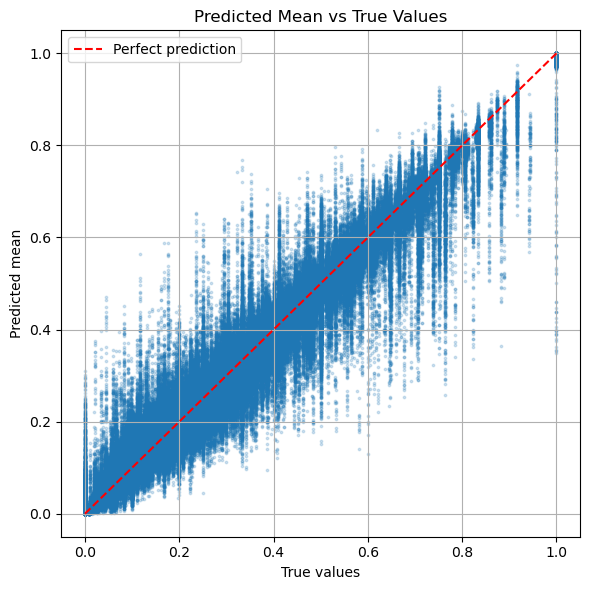

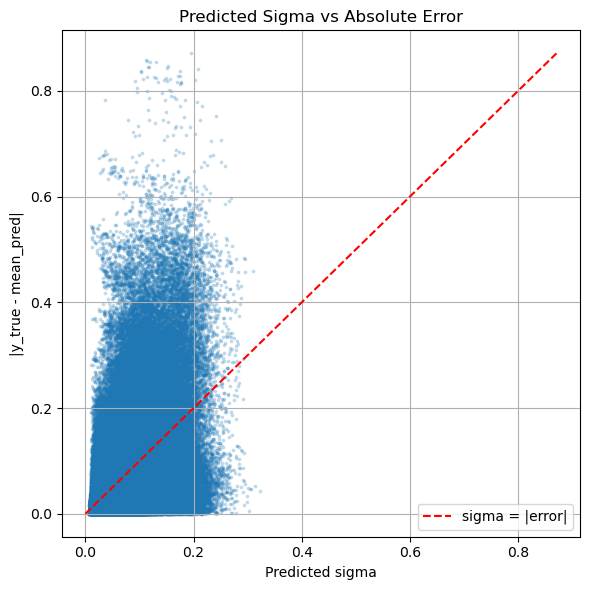

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Step 1 — 提取 mean, sigma, truth
# ------------------------------


# model_samples: (412, 20, 12, 275)
# 在 sample 维度(axis=1)计算标准差
y_pred_sigma = np.std(model_samples, axis=1)  # -> (412, 12, 275)

# ground_truths: (412, 12, 275)
y_true = ground_truths

# ------------------------------
# Step 2 — reshape 成一维
# ------------------------------
y_pred_mean_flat  = y_pred_mean.reshape(-1)
y_pred_sigma_flat = y_pred_sigma.reshape(-1)
y_true_flat       = y_true.reshape(-1)

print("Flattened size:", len(y_true_flat))


# ------------------------------
# 绘图函数 1：mean vs true
# ------------------------------
def plot_mean_vs_true(y_true, y_pred_mean):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred_mean, alpha=0.2, s=3)
    min_val = min(y_true.min(), y_pred_mean.min())
    max_val = max(y_true.max(), y_pred_mean.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')

    plt.xlabel("True values")
    plt.ylabel("Predicted mean")
    plt.title("Predicted Mean vs True Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------
# 绘图函数 2：sigma vs |error|
# ------------------------------
def plot_sigma_vs_error(y_true, y_pred_mean, y_pred_sigma):
    abs_error = np.abs(y_true - y_pred_mean)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_pred_sigma, abs_error, alpha=0.2, s=3)
    plt.xlabel("Predicted sigma")
    plt.ylabel("|y_true - mean_pred|")
    plt.title("Predicted Sigma vs Absolute Error")
    plt.grid(True)

    max_val = max(y_pred_sigma.max(), abs_error.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='sigma = |error|')
    plt.legend()

    plt.tight_layout()
    plt.show()


# ------------------------------
# Step 3 — 绘图
# ------------------------------
plot_mean_vs_true(y_true_flat, y_pred_mean_flat)
plot_sigma_vs_error(y_true_flat, model_predictions.reshape(-1), y_pred_sigma_flat)


In [30]:
y_pred_sigma_flat.max()

0.13881025

In [31]:
abs_error = np.abs(y_true.reshape(-1) - model_predictions.reshape(-1))

In [32]:
abs_error.mean()

0.012668593

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

# =============================
# 输入数据（替换为你的预测）
# =============================
# y_true:       shape (N,)
# y_pred_mean:  shape (N,)
# y_pred_quantiles: shape (N, Q)
# quantile_levels: shape (Q,)

# y_true = ...
# y_pred_mean = ...
# y_pred_quantiles = ...
# quantile_levels = ...

# ===============================================================
# 1. 诊断 A：系统性低估真实值 (Mean Bias)
# ===============================================================
def diagnose_mean_bias(y_true, y_pred_mean):
    bias = np.mean(y_pred_mean - y_true)
    print("🧪 Mean Bias (预测 - 真实):", bias)

    if bias < 0:
        print("⚠️  模型系统性低估真实值（预测均值偏小）")
    elif bias > 0:
        print("⚠️  模型系统性高估真实值（预测均值偏大）")
    else:
        print("✔ 无明显均值偏差")

# ===============================================================
# 2. 诊断 B：覆盖率（Coverage）
# ===============================================================
def diagnose_coverage(y_true, y_pred_quantiles, quantiles):
    print("\n🧪 Coverage 检查：")
    for i, q in enumerate(quantiles):
        coverage = np.mean(y_true <= y_pred_quantiles[:, i])
        print(f"  q={q:.2f}:  模型覆盖率={coverage:.3f}")

    print("\n⚠️ 若所有 coverage < quantiles → 预测分布过窄（Under-dispersion）")
    print("⚠️ 若所有 coverage > quantiles → 预测分布过宽（Over-dispersion）")

# ===============================================================
# 3. 诊断 C：分位数误差：模型 quantile vs 真实 quantile
# ===============================================================
def diagnose_quantile_shift(y_true, y_pred_quantiles, quantiles):
    print("\n🧪 分位数偏移检查（真实分位对齐 vs 模型预测）：")

    true_sorted = np.sort(y_true)
    N = len(y_true)

    for i, q in enumerate(quantiles):
        true_q = true_sorted[int(q * (N - 1))]
        pred_q = np.mean(y_pred_quantiles[:, i])

        print(f"  q={q:.2f}: 真实分位={true_q:.3f}, 预测分位={pred_q:.3f}, 差={pred_q-true_q:.3f}")

# ===============================================================
# 4. 诊断 D：PIT Histogram（检验分布宽度/偏移）
# ===============================================================
def diagnose_pit(y_true, y_pred_quantiles, quantiles):
    pits = np.zeros_like(y_true, dtype=np.float32)
    for i in range(len(y_true)):
        pits[i] = percentileofscore(y_pred_quantiles[i], y_true[i]) / 100.0

    plt.figure(figsize=(6,4))
    plt.hist(pits, bins=20, density=True, alpha=0.7)
    plt.axhline(1.0, color="red", linestyle="--")
    plt.title("PIT Histogram")
    plt.show()

    # 自动判断
    hist, _ = np.histogram(pits, bins=10)
    left = hist[:3].sum()
    right = hist[-3:].sum()
    mid = hist[4:6].sum()

    if left > mid and right > mid:
        print("⚠️ U 型 → Under-dispersion（预测分布太窄）")
    elif mid > left and mid > right:
        print("⚠️ ∧ 型 → Over-dispersion（预测分布太宽）")
    elif np.mean(pits) < 0.45:
        print("⚠️ 全体左偏 → 模型预测均值偏大（系统性高估）")
    elif np.mean(pits) > 0.55:
        print("⚠️ 全体右偏 → 模型预测均值偏小（系统性低估）")
    else:
        print("✔ PIT 分布合理")

# ===============================================================
# 5. 诊断 E：Reliability Diagram
# ===============================================================
def reliability_diagram(y_true, y_pred_quantiles, quantiles):
    obs = []
    for i, q in enumerate(quantiles):
        obs.append(np.mean(y_true <= y_pred_quantiles[:, i]))

    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], "--", color="red", label="perfect reliability")
    plt.plot(quantiles, obs, "o-", color="blue", label="model")
    plt.xlabel("Predicted Quantiles")
    plt.ylabel("Observed Frequencies")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid()
    plt.show()

    # 自动判断
    if all(o < q for o, q in zip(obs, quantiles)):
        print("⚠️ Reliability 曲线整体在下方 → 模型分布过窄 + 系统性低估真实值")
    elif all(o > q for o, q in zip(obs, quantiles)):
        print("⚠️ Reliability 曲线整体在上方 → 模型分布过宽 + 系统性高估真实值")
    else:
        print("✔ Reliability 正常")

# ===============================================================
# ⛳ 一键运行所有诊断
# ===============================================================
def run_all_diagnosis(y_true, y_pred_mean, y_pred_quantiles, quantiles):
    print("=============== 🧠 Calibration Diagnostic Report ===============")
    diagnose_mean_bias(y_true, y_pred_mean)
    diagnose_coverage(y_true, y_pred_quantiles, quantiles)
    diagnose_quantile_shift(y_true, y_pred_quantiles, quantiles)
    diagnose_pit(y_true, y_pred_quantiles, quantiles)
    reliability_diagram(y_true, y_pred_quantiles, quantiles)
    print("============================== END ==============================")

# 示例调用：
# run_all_diagnosis(y_true, y_pred_mean, y_pred_quantiles, quantile_levels)


(412, 12, 275, 10)
=============== 🧠 Calibration Diagnostic Report ===============
🧪 Mean Bias (预测 - 真实): -0.0041294345
⚠️  模型系统性低估真实值（预测均值偏小）

🧪 Coverage 检查：
  q=0.10:  模型覆盖率=0.166
  q=0.20:  模型覆盖率=0.261
  q=0.30:  模型覆盖率=0.355
  q=0.40:  模型覆盖率=0.447
  q=0.50:  模型覆盖率=0.537
  q=0.60:  模型覆盖率=0.625
  q=0.70:  模型覆盖率=0.710
  q=0.80:  模型覆盖率=0.794
  q=0.90:  模型覆盖率=0.878
  q=1.00:  模型覆盖率=0.970

⚠️ 若所有 coverage < quantiles → 预测分布过窄（Under-dispersion）
⚠️ 若所有 coverage > quantiles → 预测分布过宽（Over-dispersion）

🧪 分位数偏移检查（真实分位对齐 vs 模型预测）：
  q=0.10: 真实分位=0.060, 预测分位=0.177, 差=0.117
  q=0.20: 真实分位=0.100, 预测分位=0.195, 差=0.095
  q=0.30: 真实分位=0.136, 预测分位=0.208, 差=0.072
  q=0.40: 真实分位=0.168, 预测分位=0.219, 差=0.051
  q=0.50: 真实分位=0.202, 预测分位=0.229, 差=0.027
  q=0.60: 真实分位=0.235, 预测分位=0.240, 差=0.005
  q=0.70: 真实分位=0.278, 预测分位=0.251, 差=-0.026
  q=0.80: 真实分位=0.336, 预测分位=0.265, 差=-0.071
  q=0.90: 真实分位=0.458, 预测分位=0.286, 差=-0.173
  q=1.00: 真实分位=1.000, 预测分位=0.348, 差=-0.652


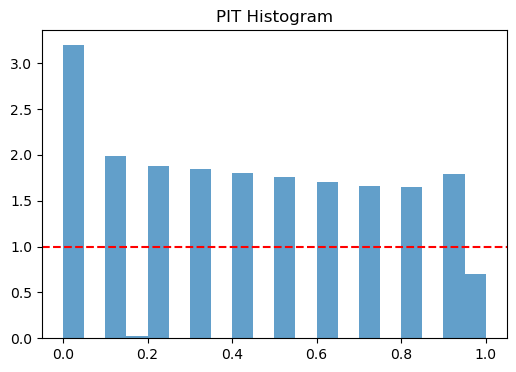

⚠️ U 型 → Under-dispersion（预测分布太窄）


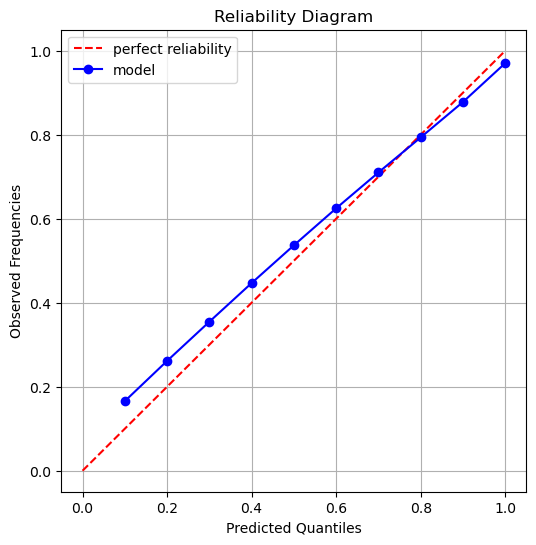

✔ Reliability 正常
============================== END ==============================


In [67]:
import numpy as np

# model_samples: (412, 20, 12, 275)
# ground_truths: (412, 12, 275)

quantile_levels = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

# 计算各分位数
# 输出 shape: (412, 12, 275, Q)
pred_quantiles = np.quantile(model_samples, quantile_levels, axis=1)  
pred_quantiles = np.moveaxis(pred_quantiles, 0, -1)  
# 现在 pred_quantiles shape = (412, 12, 275, Q)

print(pred_quantiles.shape)
# ground_truths: (412, 12, 275)
y_true = ground_truths.reshape(-1)   # shape = (412*12*275,)

# pred quantiles: (412, 12, 275, Q)
y_pred_quantiles = pred_quantiles.reshape(-1, len(quantile_levels))
y_pred_mean = np.mean(model_samples, axis=1)   # (412, 12, 275)
y_pred_mean = y_pred_mean.reshape(-1)
run_all_diagnosis(
    y_true,
    y_pred_mean,
    y_pred_quantiles,
    quantile_levels
)
